In [4]:
import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
###* Load the dataset
dataset = load_dataset('positions_all_statics.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [3]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for letter in h5file.keys():
        positions = h5file[letter]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([letter]*positions.shape[1]) # extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(4129,)

In [4]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (84, 192)
Data shape 1 (84, 200)
Data shape 2 (84, 200)
Data shape 3 (84, 200)
Data shape 4 (84, 200)
Data shape 5 (84, 200)
Data shape 6 (84, 200)
Data shape 7 (84, 200)
Data shape 8 (84, 200)
Data shape 9 (84, 198)
Data shape 10 (84, 200)
Data shape 11 (84, 193)
Data shape 12 (84, 202)
Data shape 13 (84, 203)
Data shape 14 (84, 200)
Data shape 15 (84, 203)
Data shape 16 (84, 202)
Data shape 17 (84, 204)
Data shape 18 (84, 208)
Data shape 19 (84, 161)
Data shape 20 (84, 163)


#### Remember nx -> 21*4 (positions in x and y)     m -> number of samples

In [5]:
label_encoder = LabelEncoder() ###* LETTERS TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 21


(4129,)

In [6]:
label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O',
       'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y'], dtype='<U1')

### For every sample m we have one label

In [7]:
data = np.concatenate(data_h5,axis=1)
data.shape

(84, 4129)

#### sklearn needs data.shape = (m, nx), where:
#### m is the number of samples
#### nx number of featues (positions in this case)

In [8]:
data = data.T
data.shape


(4129, 84)

In [9]:
data[0,:]

array([383,  58, 349, 107, 410,  62, 333, 102, 434,  65, 301,  92, 456,
        69, 279,  86, 476,  72, 268,  82, 412,  62, 271,  83, 418,  63,
       251,  77, 418,  63, 277,  85, 414,  62, 283,  87, 393,  59, 273,
        84, 400,  60, 258,  79, 403,  61, 290,  89, 398,  60, 288,  88,
       374,  56, 278,  85, 380,  57, 267,  82, 385,  58, 294,  90, 381,
        57, 292,  90, 355,  53, 286,  88, 361,  54, 276,  85, 369,  55,
       293,  90, 367,  55, 295,  90], dtype=int64)

In [10]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.4)

In [11]:
X_train.shape, y_train.shape, X.shape, Y.shape

((2477, 84), (2477,), (1652, 84), (1652,))

#### Now we have our train dataset but we need a dev and test dataset

In [12]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [13]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 2477 samples
Dev set: 826 samples
Test set: 826 samples


##### We have 60% for training and 20% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #* Normalize X_train using the mean and standard deviation of the training set
X_dev = scaler.transform(X_dev)  #* Normalize X_test using the mean and standard deviation of the training set
X_test = scaler.transform(X_test)  #* Normalize X_test using the mean and standard deviation of the training set

### ONE HOT to create our matrix with labels

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

c:\Users\hgera\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((2477, 21), (826, 21), (826, 21))

In [16]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

5     55
4     48
7     46
9     46
14    46
17    46
20    44
15    42
16    41
13    40
3     40
10    39
2     38
12    37
18    37
6     34
8     33
19    33
0     29
11    28
1     24
Name: count, dtype: int64


#### Let's to build our first NEURAL NETWORK

c:\Users\hgera\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.2044 - loss: 3.0961 - val_categorical_accuracy: 0.4649 - val_loss: 2.0071
Epoch 2/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.5602 - loss: 1.7458 - val_categorical_accuracy: 0.6392 - val_loss: 1.5164
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.7082 - loss: 1.3288 - val_categorical_accuracy: 0.7506 - val_loss: 1.2111
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.8022 - loss: 1.1021 - val_categorical_accuracy: 0.8087 - val_loss: 1.0469
Epoch 5/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.8334 - loss: 0.9847 - val_categorical_accuracy: 0.8378 - val_loss: 0.9477
Epoch 6/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.8555 - loss: 0.9058 - val_categorical_accuracy: 0.8487 - val_loss: 0.8625
Epoch 7/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.880

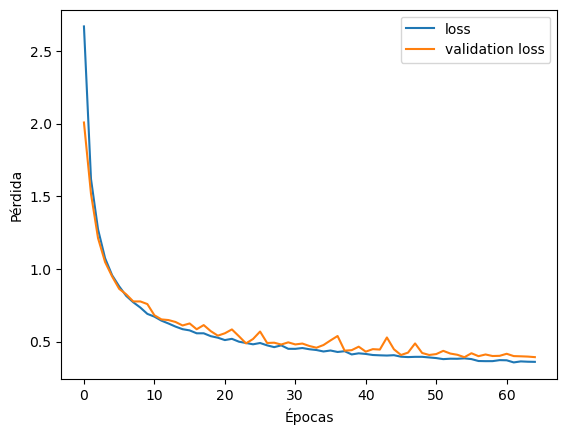

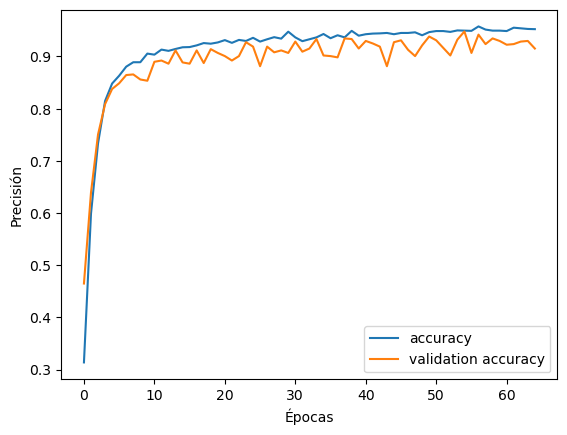

In [17]:
from tensorflow.keras.optimizers import Adam
num_classes = y_train_onehot.shape[1]  # Número de clases

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(84,)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Dropout con 50% de probabilidad
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(X_train, y_train_onehot,
                    epochs=100,
                    batch_size=4,
                    validation_data=(X_dev, y_dev_onehot),
                    callbacks=[early_stopping])

# Opcional: Graficar la pérdida y la precisión durante el entrenamiento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [18]:
max(history.history['loss'])

2.668036699295044

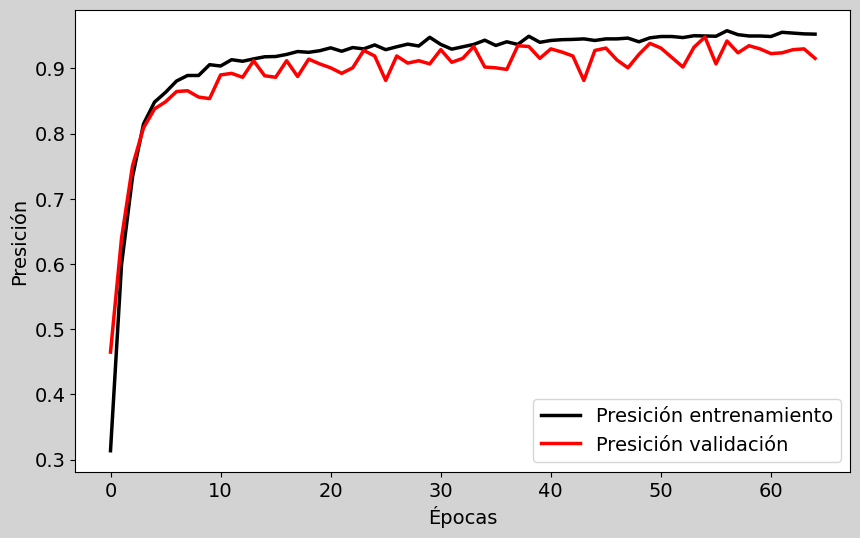

In [28]:

plt.rcParams.update({'font.size': 14})

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar la precisión
ax.plot(history.history['categorical_accuracy'], label='Presición entrenamiento', color='black', linewidth=2.5, linestyle='-') 
ax.plot(history.history['val_categorical_accuracy'], label='Presición validación', color='red', linewidth=2.5, linestyle='-')

# Configurar etiquetas y leyenda
ax.set_xlabel('Épocas')
ax.set_ylabel('Presición')
ax.legend()

# Agregar una cuadrícula
# ax.grid()

# Configurar el fondo del área de los ejes
ax.set_facecolor('white')

# Configurar el fondo del área fuera de los ejes
fig.patch.set_facecolor('lightgrey')
fig.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_python.pdf')
# Mostrar la figura
plt.show()

# Guardar la figura (descomentando la línea si es necesario)


In [41]:
c_acuracy = history.history['categorical_accuracy'][0::5]
v_acuracy = history.history['val_categorical_accuracy'][0::5]
epocas = np.arange(1, len(history.history['categorical_accuracy']) + 1, 5)


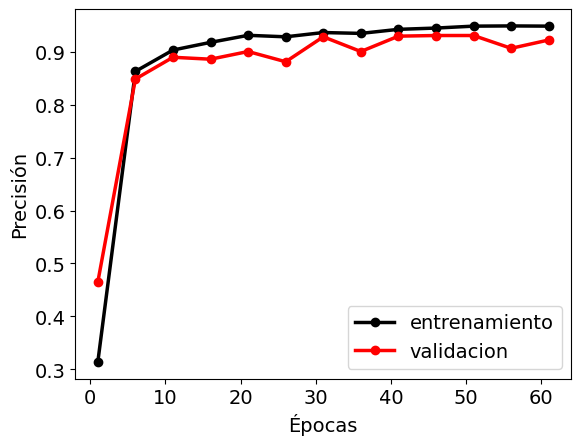

In [55]:
plt.plot(epocas,c_acuracy, label='entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas,v_acuracy, label='validacion', color='red', linewidth=2.5, linestyle='-', marker='o')
plt.legend()

plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_python.pdf')


In [20]:
# Evaluar el modelo
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Acuraccy on training data: {test_acc:.2f}')
print(f'Loss on training data: {test_loss:.2f}')


******************************************************************************************************************************************************
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9401 - loss: 0.3873 
Acuraccy on training data: 0.95
Loss on training data: 0.37


In [ ]:
#* Save the model
path_save = '..\\..\\models\\Trained\\signs\\all_statics_model.h5'
model.save(path_save)

In [22]:
model = tf.keras.models.load_model(path_save)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599 (10.16 KB)

 Trainable params: 2,597 (10.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
# Supongamos que tienes datos nuevos para predecir
dict_labels = {i: letter for i, letter in enumerate(label_encoder.classes_)}
new_data = data_h5[2][:, 119 ]  # Supongamos que solo tenemos un dato nuevo
new_data = new_data.reshape(1, -1)  # Convertirlo a un arreglo 2D
print(new_data.shape)
# Preprocesar los datos nuevos (normalización, etc.)
new_data_normalized = scaler.transform(new_data)  # Normalización Z-score

# Hacer predicciones
predictions = model.predict(new_data_normalized)

# Convertir las predicciones a etiquetas
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicción: {dict_labels[predicted_class[0]]}')

(1, 84)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicción: C


#### SAVE the values of the normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

joblib.dump(scaler, '..\\..\\models\\Trained\\signs\\all_statics_scaler.pkl')


Escalador ajustado y guardado en 'scaler.pkl'


(-0.5, 699.5, 499.5, -0.5)

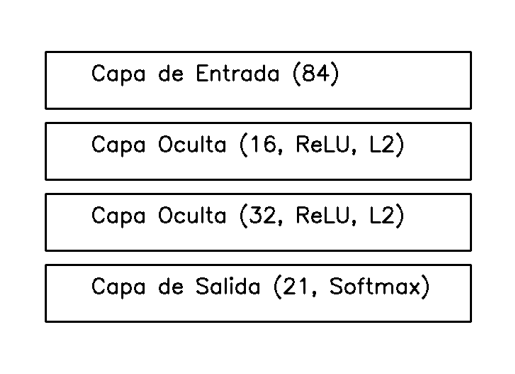

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para la red neuronal
input_shape = 84  # Número de neuronas de entrada
num_classes = 21  # Número de neuronas de salida (clases)
hidden_layers = [(16, 'ReLU', 'L2'), (32, 'ReLU', 'L2')]  # Capas ocultas con número de neuronas, activación y regularización

# Crear una imagen en blanco
height, width = 500, 700  # Dimensiones de la imagen
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Fondo blanco

# Coordenadas iniciales y finales para dibujar las capas
start_x = 50
end_x = width - 50
layer_height = 100  # Altura de cada capa

# Dibujar la capa de entrada
cv2.putText(image, f'    Capa de Entrada ({input_shape})', (start_x, layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, layer_height - 40), (end_x, layer_height + 40), (0, 0, 0), 2)

# Dibujar capas ocultas
for i, (neurons, activation, regularization) in enumerate(hidden_layers, start=2):
    cv2.putText(image, f'    Capa Oculta ({neurons}, {activation}, {regularization})', 
                (start_x, i * layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.rectangle(image, (start_x, i * layer_height - 40), (end_x, i * layer_height + 40), (0, 0, 0), 2)

# Dibujar la capa de salida
cv2.putText(image, f'    Capa de Salida ({num_classes}, Softmax)', (start_x, (len(hidden_layers) + 2) * layer_height), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, (len(hidden_layers) + 2) * layer_height - 40), 
              (end_x, (len(hidden_layers) + 2) * layer_height + 40), (0, 0, 0), 2)

# Mostrar la imagen
# cv2.imshow('Red Neuronal', image)
plt.imshow(image)
plt.axis('off')

